In [1]:
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from stochman import nnj
from stochman.hessian import HessianCalculator
from stochman.laplace import DiagLaplace

import matplotlib.pyplot as plt

### Data

In [2]:
_batch_size = 1
#x = torch.randn(_batch_size, 1, 512, 512)
x = torch.zeros(_batch_size, 1, 512, 512)
x[:, :, 200:300, :] = torch.ones(_batch_size, 1, 100, 512)

(-0.5, 511.5, 511.5, -0.5)

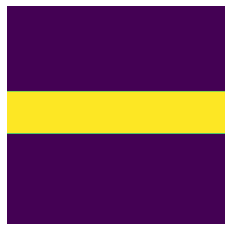

In [3]:
plt.imshow(x[0,0].detach().numpy())
plt.axis('off')

# U-Net

### Model

In [4]:
UNet = nnj.Sequential(
                nnj.Conv2d(1, 64, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Conv2d(64, 64, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Flatten(),
                nnj.SkipConnection(
                                nnj.Reshape(64,512,512),
                                nnj.MaxPool2d(2),
                                nnj.Conv2d(64, 128, 3, stride=1, padding=1),
                                nnj.Tanh(),
                                nnj.Conv2d(128, 128, 3, stride=1, padding=1),
                                nnj.Tanh(),
                                nnj.Flatten(),
                                nnj.SkipConnection(
                                                nnj.Reshape(128,256,256),
                                                nnj.MaxPool2d(2),
                                                nnj.Conv2d(128, 256, 3, stride=1, padding=1),
                                                nnj.Tanh(),
                                                nnj.Conv2d(256, 256, 3, stride=1, padding=1),
                                                nnj.Tanh(),
                                                nnj.Flatten(),
                                                nnj.SkipConnection(
                                                                nnj.Reshape(256,128,128),
                                                                nnj.MaxPool2d(2),
                                                                nnj.Conv2d(256, 512, 3, stride=1, padding=1),
                                                                nnj.Tanh(),
                                                                nnj.Conv2d(512, 512, 3, stride=1, padding=1),
                                                                nnj.Tanh(),
                                                                nnj.Flatten(),
                                                                nnj.SkipConnection(
                                                                                nnj.Reshape(512,64,64),
                                                                                nnj.MaxPool2d(2),
                                                                                nnj.Conv2d(512, 1024, 3, stride=1, padding=1),
                                                                                nnj.Tanh(),
                                                                                nnj.Conv2d(1024, 512, 3, stride=1, padding=1),
                                                                                nnj.Tanh(),
                                                                                nnj.Upsample(scale_factor=2),
                                                                                nnj.Flatten(),
                                                                                add_hooks=True
                                                                ),
                                                                nnj.Reshape(1024,64,64),
                                                                nnj.Conv2d(1024, 512, 3, stride=1, padding=1),
                                                                nnj.Tanh(),
                                                                nnj.Conv2d(512, 256, 3, stride=1, padding=1),
                                                                nnj.Tanh(),
                                                                nnj.Upsample(scale_factor=2),
                                                                nnj.Flatten(),
                                                                add_hooks=True
                                                ),
                                                nnj.Reshape(512,128,128),
                                                nnj.Conv2d(512, 256, 3, stride=1, padding=1),
                                                nnj.Tanh(),
                                                nnj.Conv2d(256, 128, 3, stride=1, padding=1),
                                                nnj.Tanh(),
                                                nnj.Upsample(scale_factor=2),
                                                nnj.Flatten(),
                                                add_hooks=True
                                ),
                                nnj.Reshape(256,256,256),
                                nnj.Conv2d(256, 128, 3, stride=1, padding=1),
                                nnj.Tanh(),
                                nnj.Conv2d(128, 64, 3, stride=1, padding=1),
                                nnj.Tanh(),
                                nnj.Upsample(scale_factor=2),
                                nnj.Flatten(),
                                add_hooks=True
                ),
                nnj.Reshape(128,512,512),
                nnj.Conv2d(128, 64, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Conv2d(64, 64, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Conv2d(64, 1, 1, stride=1, padding=0),
                add_hooks=True
        )

...
insert some training here
...

### Hessian

In [5]:
h = HessianCalculator(wrt = "weight", loss_func = "mse", shape="diagonal", speed="fast")
hessian = h.compute_hessian(x, UNet)

hessian.shape

torch.Size([21976513])

### Laplace

In [6]:
# mean parameter is the center of the Gaussian
mean_parameter = parameters_to_vector(UNet.parameters())

# get samples of Neural Networks according to the Gaussian N(mu="mean_parameter", Sigma=hessian^{-1})
laplace = DiagLaplace()
standard_deviation = laplace.posterior_scale(hessian, prior_prec=1)
samples = laplace.sample(mean_parameter, standard_deviation, n_samples=15)

In [7]:
# do one forward pass for each NN
vals=[]
for sample in samples:
    vector_to_parameters(sample, UNet.parameters())

    val = UNet(x)
    vals.append(val)

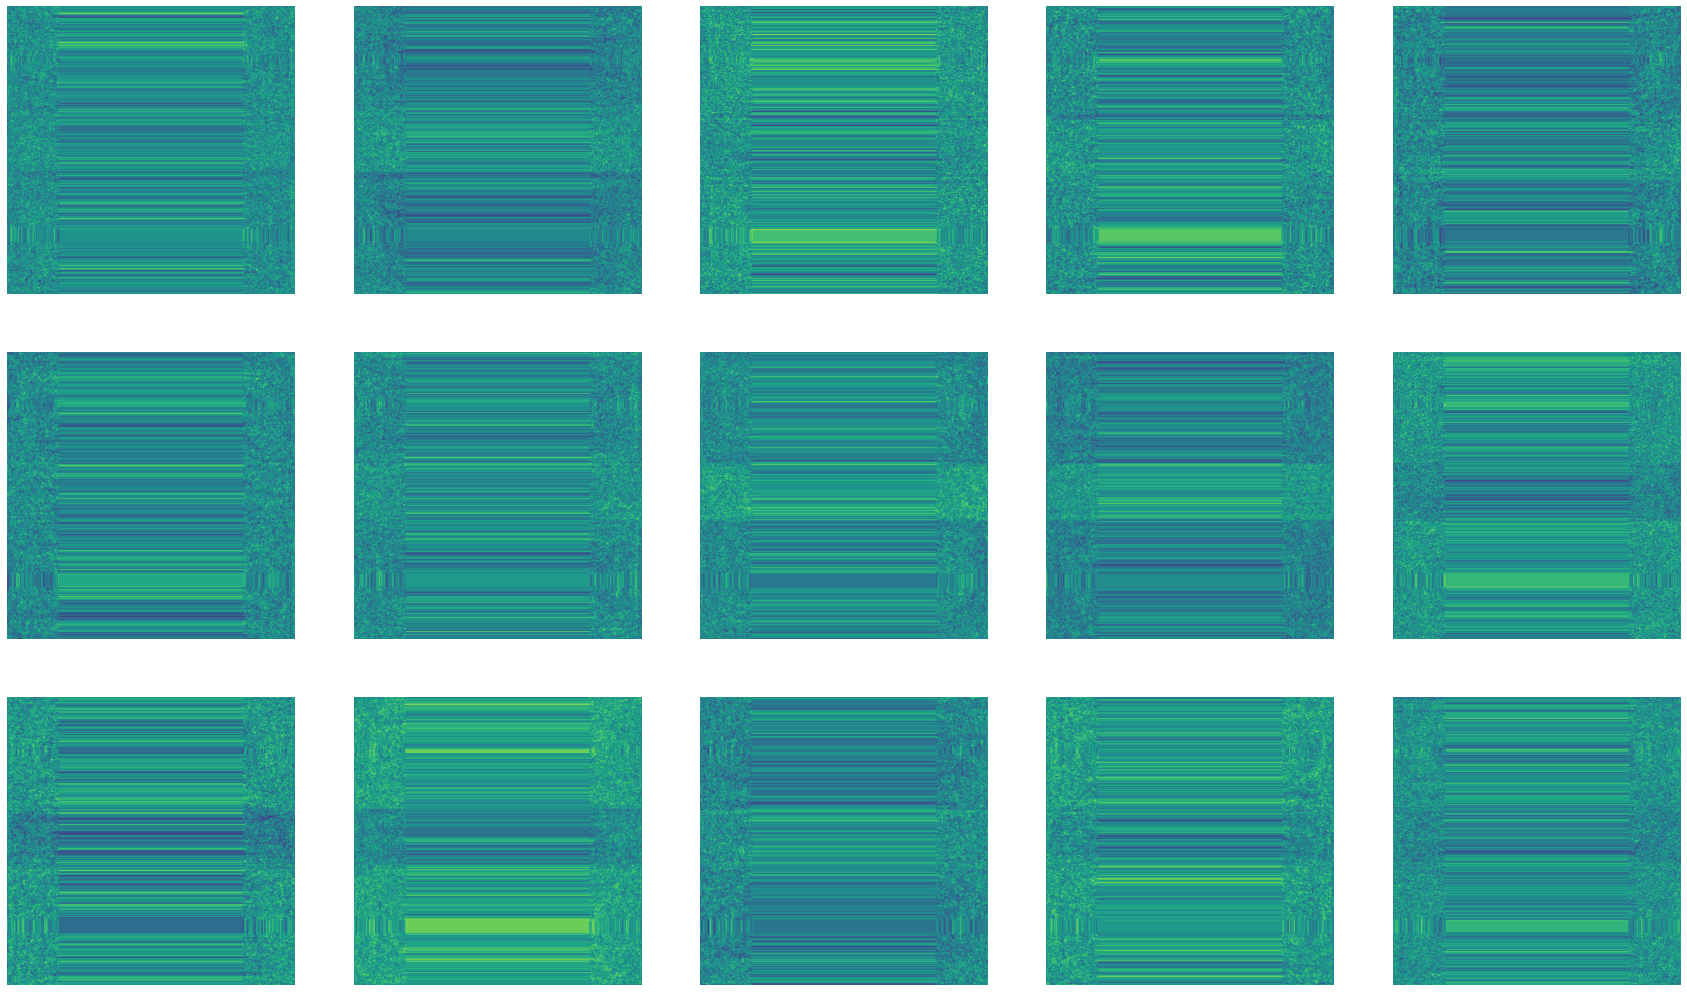

In [8]:
f, axarr = plt.subplots(3, 5, figsize=(30, 18))
for i, ax in enumerate(axarr.flat):
    ax.imshow(vals[i][0,0].detach().numpy())
    ax.axis('off')
plt.show()